# Telco customer churn

The Telco customer churn data contains information about a fictional Telco company that provided home phone and Internet services to 7043 customers in California in Q3. It indicates which customers have left, stayed, or signed up for their service. Multiple important demographics are included for each customer, as well as a Satisfaction Score, Churn Score, and Customer Lifetime Value (CLTV) index.


Feature | Description | Values
------  | ----------  | ----------
customerID | Customer ID
gender | Whether the customer is a male or a female
SeniorCitizen | Whether the customer is a senior citizen or not | (1, 0)
Partner | Whether the customer has a partner or not | (Yes, No)
Dependents | Whether the customer has dependents or not | (Yes, No)
tenure | Number of months the customer has stayed with the company
PhoneService | Whether the customer has a phone service or not | (Yes, No)
MultipleLines | Whether the customer has multiple lines or not | (Yes, No, No phone service)
InternetService | Customer’s internet service provider | (DSL, Fiber optic, No)
OnlineSecurity | Whether the customer has online security or not | (Yes, No, No internet service)
OnlineBackup | Whether the customer has online backup or not | (Yes, No, No internet service)
DeviceProtection | Whether the customer has device protection or not | (Yes, No, No internet service)
TechSupport | Whether the customer has tech support or not | (Yes, No, No internet service)
StreamingTV | Whether the customer has streaming TV or not | (Yes, No, No internet service)
StreamingMovies | Whether the customer has streaming movies or not | (Yes, No, No internet service)
Contract | The contract term of the customer | (Month-to-month, One year, Two year)
PaperlessBilling | Whether the customer has paperless billing or not | (Yes, No)
PaymentMethod | The customer’s payment method | (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
MonthlyCharges | The amount charged to the customer monthly
TotalCharges | The total amount charged to the customer
Churn | Whether the customer churned or not | (Yes or No)

## Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split

from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV

from sklearn.linear_model import  LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay


import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

pd.set_option('display.max_columns', 100)


In [2]:
%matplotlib inline
sns.set_theme()

## Importar base de dados

In [3]:
dF_raw = pd.read_csv('Bases/Telco-Customer-Churn.csv')

## Análise dos dados

Entender como estão distribuídos os dados e quem são os preditores

In [4]:
df = dF_raw.copy()
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Informações sobre os tipos de dados e valores nulos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Análise descritiva dos dados

In [6]:
profile = ProfileReport(df, minimal=True)
profile

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


### Observações:
* **customerID** pode ser removida, pois possui alta cardinalidade e não agrega informação para modelagem
* corrigir feature **TotalCharges** para float
* colunas numéricas contínuas: **tenure**, **MonthlyCharges** e **TotalCharges**
* colunas booleanas: **gender**, **SeniorCitizen**, **Partner**, **Dependents**, **PhoneService**, **PaperlessBilling** e **Churn**
* colunas categóricas: **MultipleLines**, **InternetService**, **OnlineSecurity**, **OnlineBackup**, **DeviceProtection**, **TechSupport**, **StreamingTV**, **StreamingMovies**, **Contract** e **PaymentMethod**
* variável target: **Churn** não é balanceada

In [7]:
df.drop(columns=['customerID'], inplace=True)


In [8]:
df[['TotalCharges']].describe().T

,count,unique,top,freq
TotalCharges,7043,6531,,11


In [9]:
df.loc[df['TotalCharges'] != ' ', ['TotalCharges']].astype('float64').describe().T

,count,mean,std,min,25%,50%,75%,max
TotalCharges,7032.0,2283.300441,2266.771362,18.8,401.45,1397.475,3794.7375,8684.8


In [10]:
(1-(7032/7043))*100

0.15618344455488042

Como a feature **TotalCharges** representa a o total de cobrança aos clientes e menos de 1% das entradas possuem valores inválidos, eles serão removidos.

In [11]:
df.drop(index=df.loc[df['TotalCharges'] == ' '].index, inplace=True)

### Separar as features conforme os seus tipos
* Numérico
* Booleano
* Categórico

In [12]:
num = ['tenure', 'MonthlyCharges', 'TotalCharges']
boo = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
cat = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod', 'gender']

Variável target

In [13]:
df['Churn'].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

## Feature Engineering

### Dividir o dataset

Realizar a divisão primeiro para que o tratamento dos dados não tendencie a base de teste.

In [14]:
x = df.drop(columns=['Churn'])
y = df['Churn']

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=10)

print(f'x_train: {x_train.shape} \n'
      f'x_test:  {x_test.shape} \n'
      f'y_train: {y_train.shape} \n'
      f'y_test:  {y_test.shape} ')

x_train: (5977, 19) 
x_test:  (1055, 19) 
y_train: (5977,) 
y_test:  (1055,) 


### Variáveis numéricas

Converter para float

In [16]:
for n in num:
    x_train[n] = x_train[n].astype(float)
    x_test[n] = x_test[n].astype(float)

#### Visualização das distribuições de treino

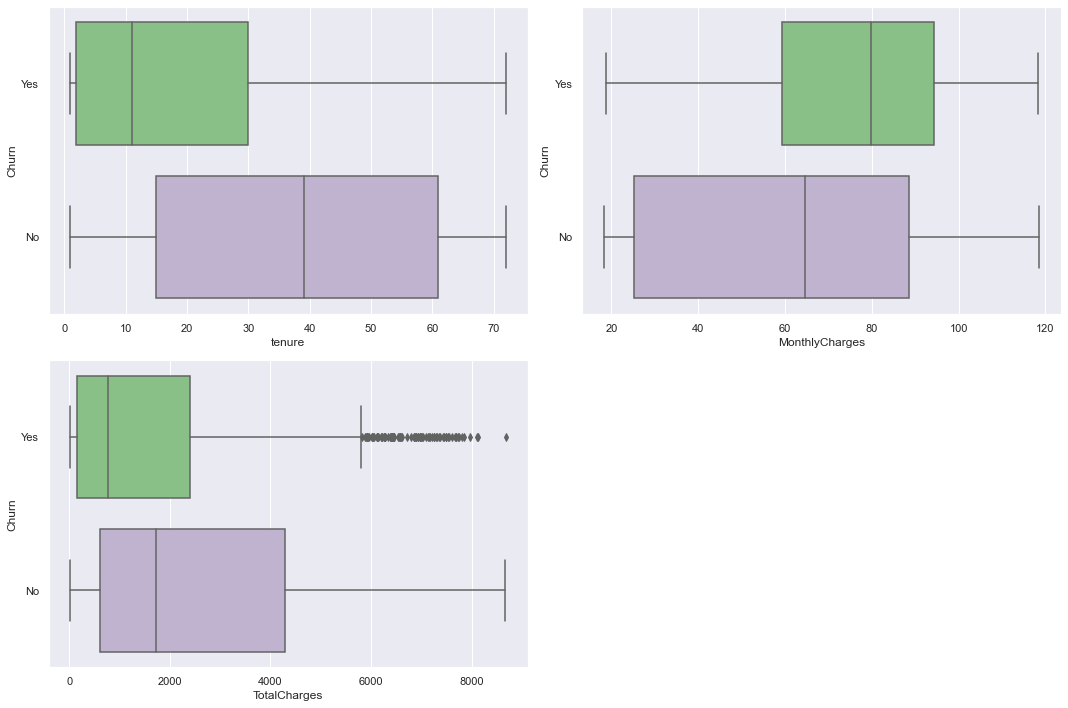

In [17]:
plt.figure(figsize=(15,10))
sns.set_theme()

for n, i in zip(num, range(1, len(num)+1)):
    plt.subplot(2,2,i)
    sns.boxplot(x=x_train[n], 
                y=y_train, 
                palette="Accent")

plt.tight_layout()
plt.show()

### Variáveis booleanas

In [18]:
x_train[boo] = x_train[boo].replace({'Yes': 1, 'No': 0})
x_test[boo] = x_test[boo].replace({'Yes': 1, 'No': 0})

y_train = y_train.replace({'Yes': 1, 'No': 0})
y_test = y_test.replace({'Yes': 1, 'No': 0})

In [19]:
x_train.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5383,Male,0,0,0,36.0,1,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,1,Electronic check,84.75,3050.15
5828,Female,0,1,1,72.0,1,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,0,Bank transfer (automatic),24.45,1709.10
2319,Male,0,1,1,11.0,1,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,0,Electronic check,90.60,1020.20


In [20]:
y_train.head(3)

5383    1
5828    0
2319    0
Name: Churn, dtype: int64

### Variáveis categóricas

In [21]:
encoder = OneHotEncoder(variables=cat, drop_last=False)

encoder.fit(x_train)

OneHotEncoder(variables=['MultipleLines', 'InternetService', 'OnlineSecurity',
                         'OnlineBackup', 'DeviceProtection', 'TechSupport',
                         'StreamingTV', 'StreamingMovies', 'Contract',
                         'PaymentMethod', 'gender'])

In [22]:
x_train = encoder.transform(x_train)
x_test = encoder.transform(x_test)

In [23]:
x_train.head(3)

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_Yes,MultipleLines_No,MultipleLines_No phone service,InternetService_Fiber optic,InternetService_No,InternetService_DSL,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_Yes,StreamingMovies_No internet service,StreamingMovies_No,Contract_Month-to-month,Contract_Two year,Contract_One year,PaymentMethod_Electronic check,PaymentMethod_Bank transfer (automatic),PaymentMethod_Mailed check,PaymentMethod_Credit card (automatic),gender_Male,gender_Female
5383,0,0,0,36.0,1,1,84.75,3050.15,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
5828,0,1,1,72.0,1,0,24.45,1709.10,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1
2319,0,1,1,11.0,1,0,90.60,1020.20,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0


### Normalização das variáveis
Para aplicação nos classificadores

In [24]:
scaler = MinMaxScaler()
scaler.fit(x_train)

x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

In [25]:
x_train.head(3)

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_Yes,MultipleLines_No,MultipleLines_No phone service,InternetService_Fiber optic,InternetService_No,InternetService_DSL,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_Yes,StreamingMovies_No internet service,StreamingMovies_No,Contract_Month-to-month,Contract_Two year,Contract_One year,PaymentMethod_Electronic check,PaymentMethod_Bank transfer (automatic),PaymentMethod_Mailed check,PaymentMethod_Credit card (automatic),gender_Male,gender_Female
0,0.0,0.0,0.0,0.492958,1.0,1.0,0.662351,0.349798,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,1.0,1.000000,1.0,0.0,0.061753,0.195050,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,0.140845,1.0,0.0,0.720618,0.115555,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Classificadores
Otimizar, treinar e testar os classificadores Regressão Logística, Random Forest e SVM para encontrar o com melhor performance.

### Regressão Logística
* Otimizar os parâmetros

In [26]:
params_grid = {
          "C":(0.01, 1, 10, 100), 
          "penalty":("l1","l2"),
          "solver": ["liblinear"]
}

In [27]:
clf = LogisticRegression()

grid_search = GridSearchCV(estimator=clf, param_grid=params_grid, n_jobs=-1, cv=3, verbose=0)

grid_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': (0.01, 1, 10, 100), 'penalty': ('l1', 'l2'),
                         'solver': ['liblinear']})

In [28]:
print(grid_search.best_params_)
best_lr = grid_search.best_estimator_

{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


* Avaliar o modelo

In [29]:
y_pred = best_lr.predict(x_test)

f1 = round(f1_score(y_test, y_pred, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, y_pred)*100,2)
precision = round(precision_score(y_test, y_pred)*100,2)
recall = round(recall_score(y_test, y_pred)*100,2)


print(f"F1 Score:        {f1}%")
print(f"Accuracy Score:  {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score:    {recall}%")

metricas = {}
metricas["LogisticRegression"]={
                            "accuracy": accuracy,
                            "precision": precision,
                            "recall": recall,
                            "f1": f1
                            }

F1 Score:        76.13%
Accuracy Score:  82.18%
Precision Score: 67.74%
Recall Score:    60.87%


### Random Forest
* Otimizar os parâmetros 

In [30]:
params_grid = {
    'max_depth': [50, 100, 150],
    'max_features': [3, 4, 5],
    'criterion':['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [2, 3, 8, 10],
    'n_estimators': [200, 300, 400, 500]
}

In [31]:
clf = RandomForestClassifier(random_state=10)

bayes_search = BayesSearchCV(estimator=clf, search_spaces=params_grid, n_jobs=-1, cv=3, verbose=0)

bayes_search.fit(x_train, y_train)

BayesSearchCV(cv=3, estimator=RandomForestClassifier(random_state=10),
              n_jobs=-1,
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_depth': [50, 100, 150],
                             'max_features': [3, 4, 5],
                             'min_samples_leaf': [1, 2, 3, 4],
                             'min_samples_split': [2, 3, 8, 10],
                             'n_estimators': [200, 300, 400, 500]})

In [32]:
print(bayes_search.best_params_)
best_rf = bayes_search.best_estimator_

OrderedDict([('criterion', 'gini'), ('max_depth', 100), ('max_features', 5), ('min_samples_leaf', 4), ('min_samples_split', 8), ('n_estimators', 400)])


* Avaliar a qualidade do modelo

In [33]:
y_pred = best_rf.predict(x_test)

f1 = round(f1_score(y_test, y_pred, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, y_pred)*100,2)
precision = round(precision_score(y_test, y_pred)*100,2)
recall = round(recall_score(y_test, y_pred)*100,2)


print(f"F1 Score:        {f1}%")
print(f"Accuracy Score:  {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score:    {recall}%")

metricas["RandomForest"] = {
                            "accuracy":accuracy,
                            "precision":precision,
                            "recall":recall,
                            "f1":f1
}

F1 Score:        75.73%
Accuracy Score:  82.09%
Precision Score: 68.2%
Recall Score:    59.06%


### SVM

* Otimizar o modelo

In [34]:
params_grid = {'kernel': ['linear','poly','rbf']}

clf = SVC(random_state=10)

bayes_search = BayesSearchCV(estimator=clf, search_spaces=params_grid, n_jobs=-1,  verbose=0)

bayes_search.fit(x_train, y_train)

BayesSearchCV(estimator=SVC(random_state=10), n_jobs=-1,
              search_spaces={'kernel': ['linear', 'poly', 'rbf']})

In [35]:
print(bayes_search.best_params_)
best_svm = bayes_search.best_estimator_

OrderedDict([('kernel', 'linear')])


* Avaliar o modelo

In [36]:
y_pred = best_svm.predict(x_test)

f1 = round(f1_score(y_test, y_pred, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, y_pred)*100,2)
precision = round(precision_score(y_test, y_pred)*100,2)
recall = round(recall_score(y_test, y_pred)*100,2)


print(f"F1 Score:        {f1}%")
print(f"Accuracy Score:  {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score:    {recall}%")

metricas["SVM"]={
                "accuracy":accuracy,
                "precision":precision,
                "recall":recall,
                "f1":f1
}

F1 Score:        74.98%
Accuracy Score:  81.61%
Precision Score: 67.37%
Recall Score:    57.61%


## Resumo de classificadores

Estipular baseline para comparação de algoritmos.

In [37]:
pd.DataFrame({
    'Churn': ['0', 
               '1'],
    'count': [df['Churn'].value_counts()[0], 
              df['Churn'].value_counts()[1]],
    'baseline': [(df['Churn'].value_counts()[0] / df.shape[0])*100,
                 (df['Churn'].value_counts()[1] / df.shape[0])*100]
})

,Churn,count,baseline
0,0,5163,73.421502
1,1,1869,26.578498


In [38]:
pd.DataFrame(metricas).T

,accuracy,precision,recall,f1
LogisticRegression,82.18,67.74,60.87,76.13
RandomForest,82.09,68.20,59.06,75.73
SVM,81.61,67.37,57.61,74.98


### Visualização das matrizes de confusão e curva ROC

In [39]:
bests = [best_lr, best_rf, best_svm]
titles = ['Regressão Linear', 'Random Forest', 'Support Vector Machine']

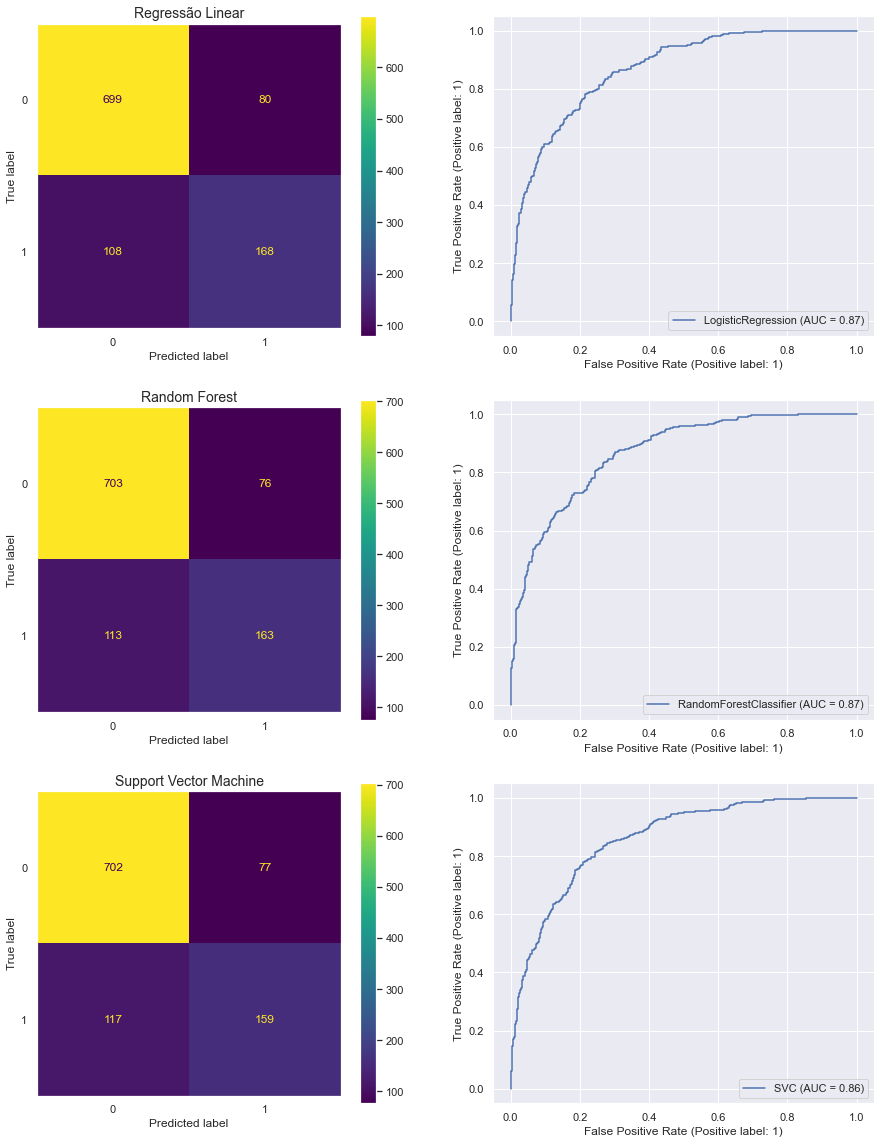

In [40]:
fig, axs = plt.subplots(3,2, figsize=(15,20))

for n,best,title in zip(range(3), bests, titles):
    ConfusionMatrixDisplay.from_estimator(best, x_test, y_test, values_format='d', ax=axs[n,0])
    axs[n,0].grid(False)
    axs[n,0].set_title(title, fontsize=14)
    RocCurveDisplay.from_estimator(best, x_test, y_test, ax=axs[n,1])
    
plt.show()


## Conclusão

Apesar de variações discretas o algoritmo que apresentou melhor performance no geral foi o de Regressão Logística. 

Mas são necessários mais testes com variação de features para que possamos encontrar melhores métricas.

